In [3]:
import json
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from utils.data_utils import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils.visualiser import visualise_dataloader_sample,visualise_dataset
from tqdm import tqdm

def create_yolo_dataset(json_files, base_path, yolo_dataset_path):
    os.makedirs(yolo_dataset_path, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(yolo_dataset_path, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(yolo_dataset_path, 'labels', split), exist_ok=True)

    all_data = []
    class_names = []

    for class_id, json_file in enumerate(tqdm(json_files,desc='Processing JSON files')):
        class_name = json_file.split('.')[0]
        class_names.append(class_name)
        
        with open(os.path.join(base_path, 'annotations', json_file), 'r') as f:
            data = json.load(f)
        
        for img_info in data['images']:
            img_path = os.path.join(base_path, img_info['path'].lstrip('../'))
            img_width, img_height = img_info['width'], img_info['height']
            
            annotation = next((ann for ann in data['annotations'] if ann['image_id'] == img_info['id']), None)
            
            if annotation:
                bbox = normalize_bbox(annotation['bbox'], img_width, img_height)
                keypoints = normalize_keypoints(annotation['keypoints'][:-3], img_width, img_height) # process all keypoints except the last one (neck)
                
                all_data.append({
                    'image_path': img_path,
                    'class_id': class_id,
                    'bbox': bbox,
                    'keypoints': keypoints
                })

    train_data, val_test_data = train_test_split(all_data, test_size=0.3, random_state=42)
    val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

    def process_split(split_name, data):
        for item in data:
            dst_img_path = os.path.join(yolo_dataset_path, 'images', split_name, os.path.basename(item['image_path']))
            shutil.copy(item['image_path'], dst_img_path)

            label_content = f"{item['class_id']} {' '.join(map(str, item['bbox'])) } {' '.join(map(str, item['keypoints']))}"
            label_filename = os.path.splitext(os.path.basename(item['image_path']))[0] + '.txt'
            with open(os.path.join(yolo_dataset_path, 'labels', split_name, label_filename), 'w') as f:
                f.write(label_content)

    process_split('train', train_data)
    process_split('val', val_data)
    process_split('test', test_data)

    yaml_content = f"""
path: {os.path.abspath(yolo_dataset_path)}
train: images/train
val: images/val
test: images/test

nc: {len(class_names)}
names: {class_names}

# Keypoint information
kpt_shape: [17, 3] # number of keypoints, number of dims (2 for x,y or 3 for x,y,visible)
flip_idx: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
"""
    with open(os.path.join(yolo_dataset_path, 'dataset.yaml'), 'w') as f:
        f.write(yaml_content)

    print(f"YOLO dataset created at {yolo_dataset_path}")

def get_dataloaders(json_files, base_path,batch_size=32, sequence_length=None):
    train_dataset, val_dataset, test_dataset = get_datasets(json_files, base_path,sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers=4, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=4, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,num_workers=4, shuffle=True, pin_memory=True)

    return train_loader, val_loader, test_loader

def visualize_nonseq_dataloader_samples():
    train_loader, val_loader, test_loader = get_dataloaders(json_files, base_path)
    print('Visualizing non-sequential data samples')
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

    images, bboxes, keypoints, labels = next(iter(train_loader))
    print(f"Sample batch - Images shape: {images.shape}")
    print(f"Sample batch - Bounding boxes shape: {bboxes.shape}")
    print(f"Sample batch - Keypoints shape: {keypoints.shape}")
    print(f"Sample batch - Labels shape: {labels.shape}")

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    # Visualize for train split
    images, bboxes, keypoints, labels = next(iter(train_loader))
    for i in range(3):
        visualise_dataloader_sample(axes[0, i], images[i], bboxes[i], keypoints[i], labels[i], f"Train - Frame {i+1}")
    axes[0, 0].set_ylabel('Train', size='large')

    # Visualize non-sequential data for validation split
    images, bboxes, keypoints, labels = next(iter(val_loader))
    for i in range(3):
        visualise_dataloader_sample(axes[1, i], images[i], bboxes[i], keypoints[i], labels[i], f"Validation - Frame {i+1}")
    axes[1, 0].set_ylabel('Validation', size='large')

    # Visualize non-sequential data for test split
    images, bboxes, keypoints, labels = next(iter(test_loader))
    for i in range(3):
        visualise_dataloader_sample(axes[2, i], images[i], bboxes[i], keypoints[i], labels[i], f"Test - Frame {i+1}")
    axes[2, 0].set_ylabel('Test', size='large')

    plt.tight_layout()
    plt.show()

def visualize_seq_dataloader_samples():
    train_loader, val_loader, test_loader = get_dataloaders(json_files, base_path, batch_size=64, sequence_length=5)

    print('Visualizing sequential data samples')
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

    images, bboxes, keypoints, labels = next(iter(train_loader))
    print(f"Sample batch - Images shape: {images.shape}")
    print(f"Sample batch - Bounding boxes shape: {bboxes.shape}")
    print(f"Sample batch - Keypoints shape: {keypoints.shape}")
    print(f"Sample batch - Labels shape: {labels.shape}")

    # Visualize the 5 frames in the sequence for one of the entries in the batch
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))

    # Function to visualize a sequence
    def visualize_sequence(ax, images, bboxes, keypoints, label, title):
        for i in range(5):
            visualise_dataloader_sample(ax[i], images[i], bboxes[i], keypoints[i], label.numpy(), f"{title} - Frame {i+1}")

    # Visualize for train split
    images, bboxes, keypoints, labels = next(iter(train_loader))
    visualize_sequence(axes[0], images[0], bboxes[0], keypoints[0], labels[0], "Train")
    axes[0, 0].set_ylabel('Train', size='large')

    # Visualize for validation split
    images, bboxes, keypoints, labels = next(iter(val_loader))
    visualize_sequence(axes[1], images[0], bboxes[0], keypoints[0], labels[0], "Validation")
    axes[1, 0].set_ylabel('Validation', size='large')

    # Visualize for test split
    images, bboxes, keypoints, labels = next(iter(test_loader))
    visualize_sequence(axes[2], images[0], bboxes[0], keypoints[0], labels[0], "Test")
    axes[2, 0].set_ylabel('Test', size='large')

    plt.tight_layout()
    plt.show()


Visualizing non-sequential data samples
Train batches: 44
Validation batches: 10
Test batches: 10
Sample batch - Images shape: torch.Size([32, 3, 320, 320])
Sample batch - Bounding boxes shape: torch.Size([32, 4])
Sample batch - Keypoints shape: torch.Size([32, 54])
Sample batch - Labels shape: torch.Size([32])


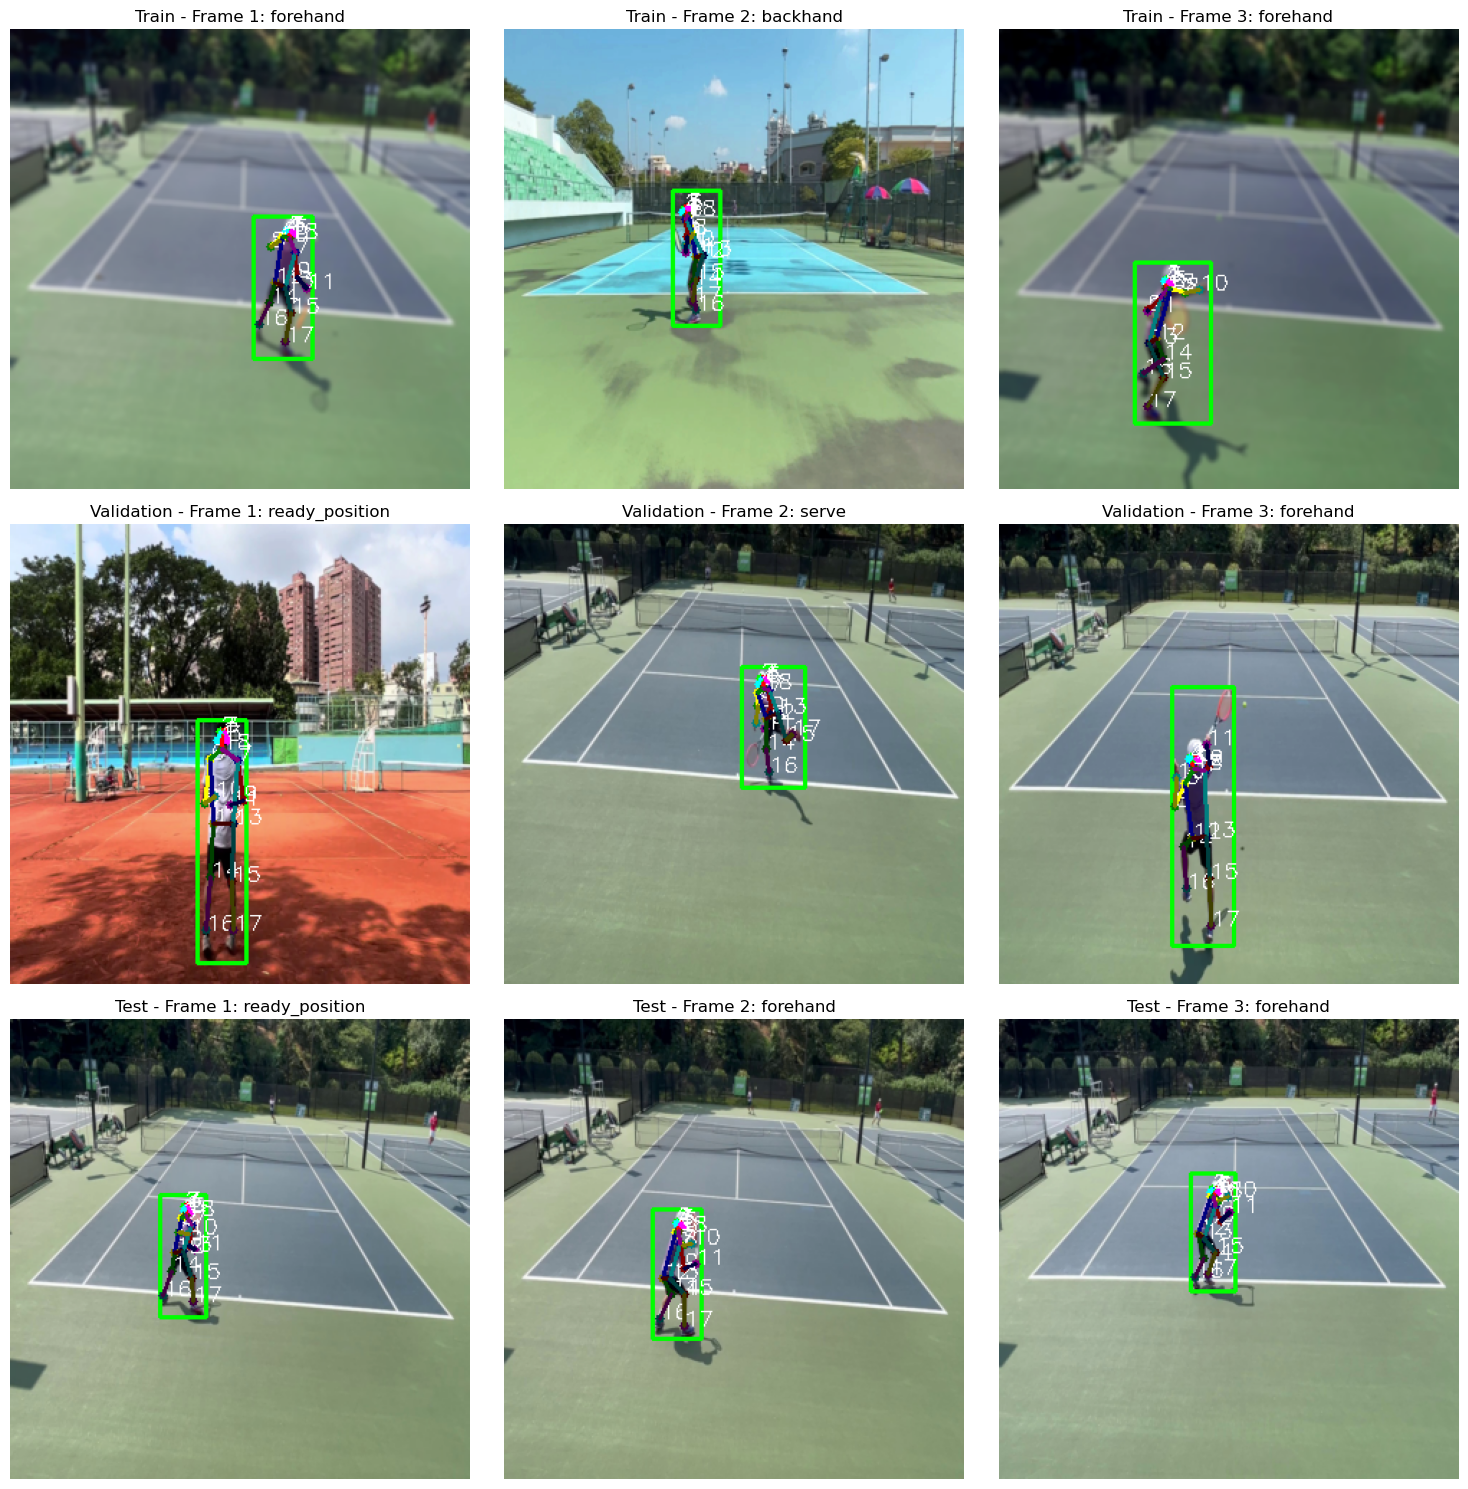

No overlaps found in data
Visualizing sequential data samples
Train batches: 22
Validation batches: 5
Test batches: 5
Sample batch - Images shape: torch.Size([64, 5, 3, 320, 320])
Sample batch - Bounding boxes shape: torch.Size([64, 5, 4])
Sample batch - Keypoints shape: torch.Size([64, 5, 54])
Sample batch - Labels shape: torch.Size([64])


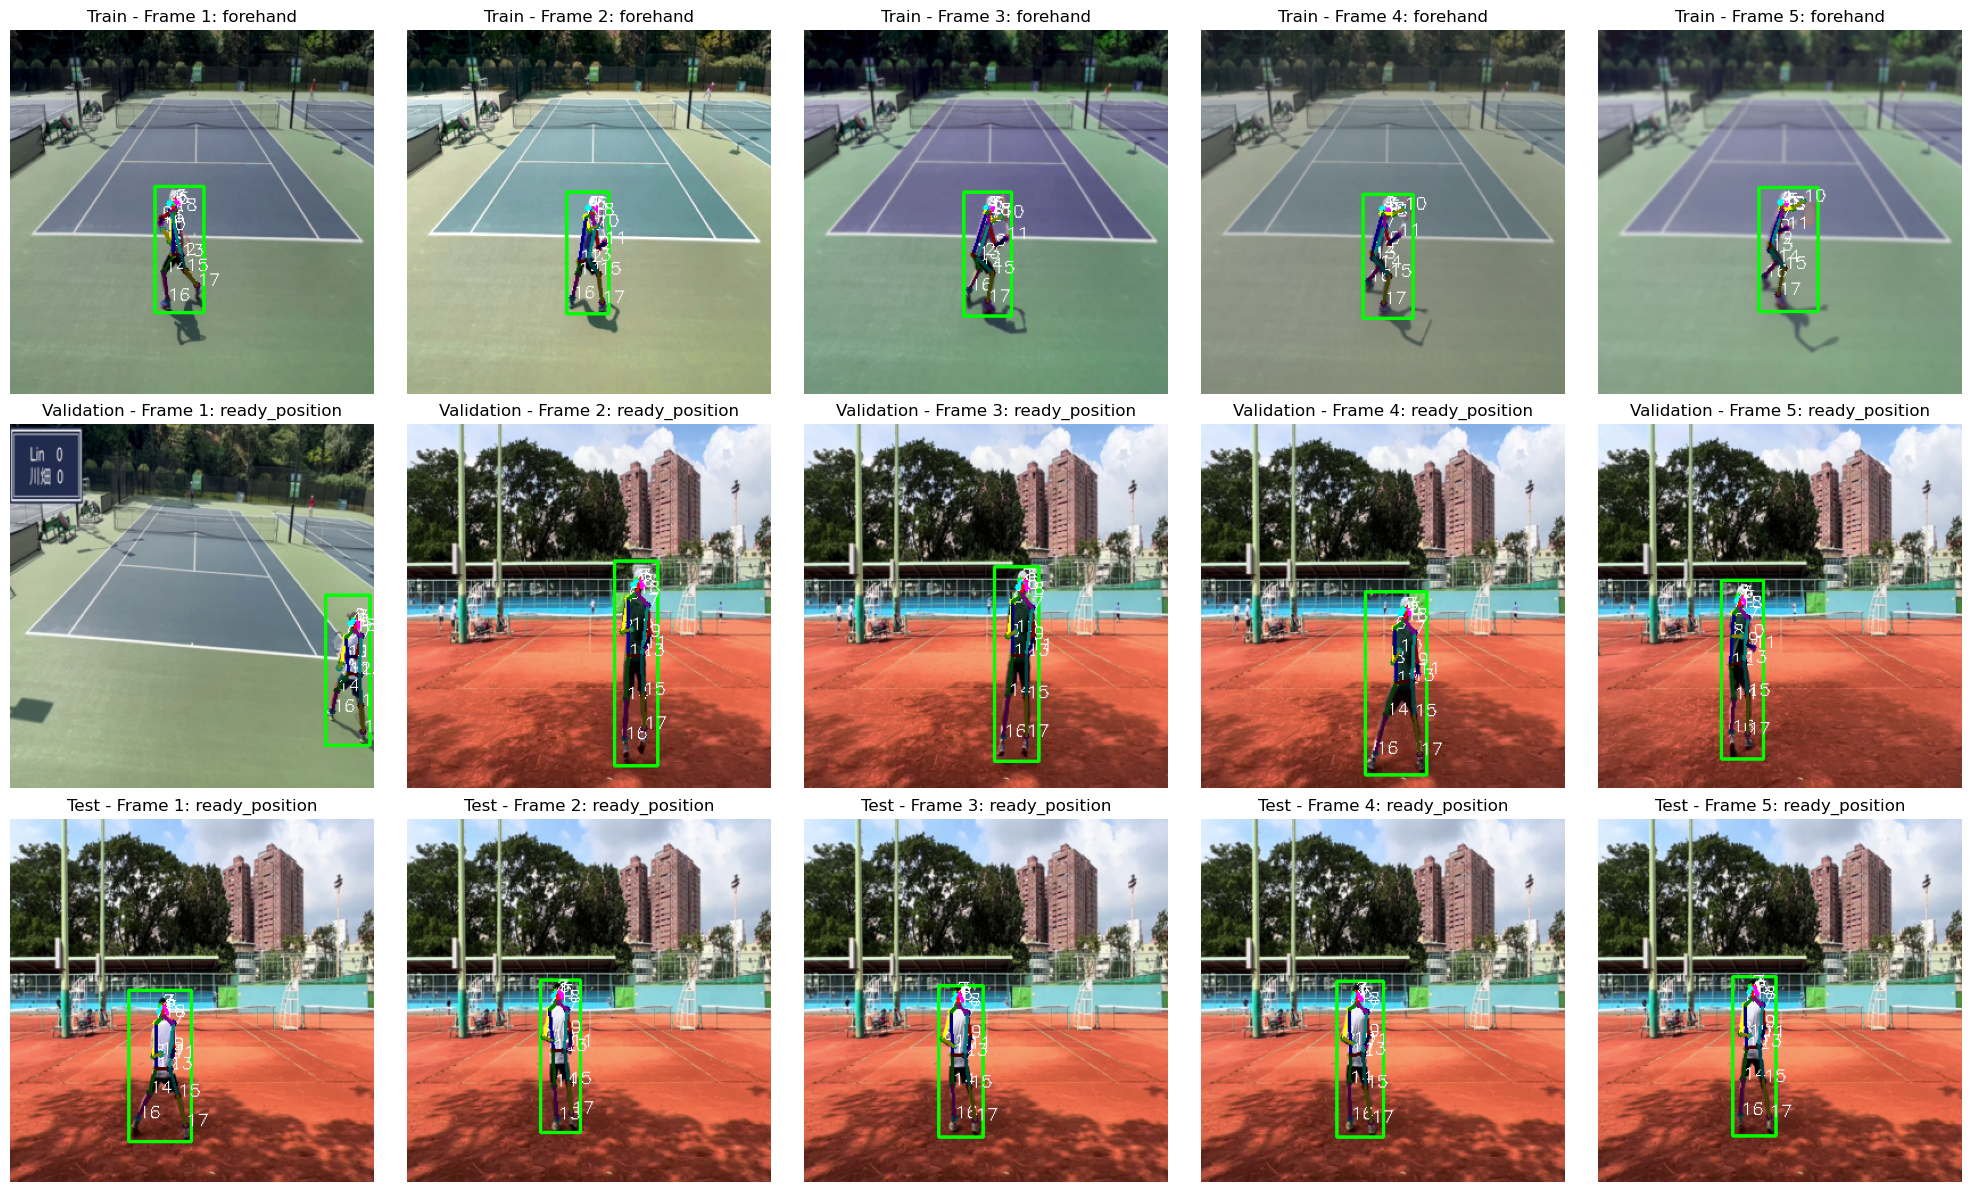

In [4]:

json_files = os.listdir("og_dataset\\annotations")
base_path = "og_dataset"
# sequence_length = None
# train_loader, val_loader, test_loader = get_dataloaders(json_files, base_path,sequence_length, batch_size=64)


# print(f"Train batches: {len(train_loader)}")
# print(f"Validation batches: {len(val_loader)}")
# print(f"Test batches: {len(test_loader)}")

# images, bboxes, keypoints, labels = next(iter(train_loader))
# print(f"Sample batch - Images shape: {images.shape}")
# print(f"Sample batch - Bounding boxes shape: {bboxes.shape}")
# print(f"Sample batch - Keypoints shape: {keypoints.shape}")
# print(f"Sample batch - Labels shape: {labels.shape}")

# print('Data types:')
# print(f"Images: {images.dtype}")
# print(f"BBoxes: {bboxes.dtype}")
# print(f"Keypoints: {keypoints.dtype}")
# print(f"Labels: {labels.dtype}")


visualize_nonseq_dataloader_samples()
visualize_seq_dataloader_samples()